<a href="https://colab.research.google.com/github/Hasaankhattak45/Machine-Learning-Projects/blob/main/LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Examining The Data**

In the first part of exercise 1, we're tasked with implementing simple linear regression to predict profits for a food truck. Suppose you are the CEO of a restaurant franchise and are considering different cities for opening a new outlet. The chain already has trucks in various cities and you have data for profits and populations from the cities. You'd like to figure out what the expected profit of a new food truck might be given only the population of the city that it would be placed in.

Let's start by examining the data which is in a file called "ex1data1.txt" in the "data" directory of my repository above. First we need to import a few libraries.

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now let's get things rolling. We can use pandas to load the data into a data frame and display the first few rows using the "head" function.

In [4]:

data = pd.read_csv("/content/drive/MyDrive/Lr-dataset.csv")
data

,X,Y
0,1,1
1,2,3
2,3,3
3,4,2
4,5,5
5,6,5


Another useful function that pandas provides out-of-the-box is the "describe" function, which calculates some basic statistics on a data set. This is helpful to get a "feel" for the data during the exploratory analysis stage of a project.

In [5]:
data.describe()


,X,Y
count,6.000000,6.000000
mean,3.500000,3.166667
std,1.870829,1.602082
min,1.000000,1.000000
25%,2.250000,2.250000
50%,3.500000,3.000000
75%,4.750000,4.500000
max,6.000000,5.000000


Examining stats about your data can be helpful, but sometimes you need to find ways to visualize it too. Fortunately this data set only has one dependent variable, so we can toss it in a scatter plot to get a better idea of what it looks like. We can use the "plot" function provided by pandas for this, which is really just a wrapper for matplotlib.

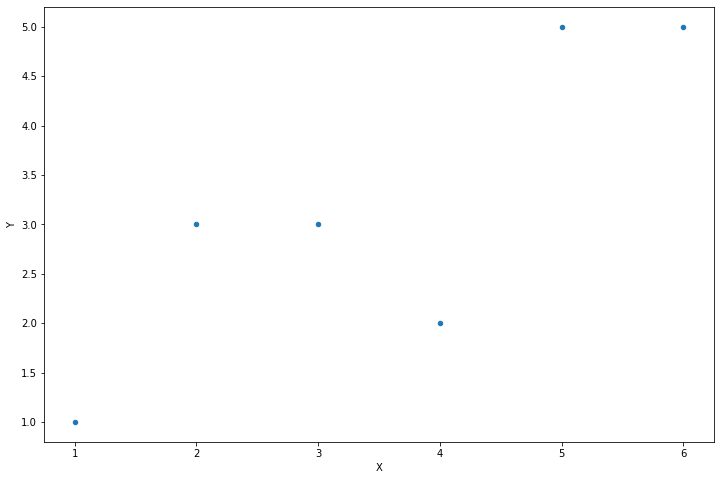

In [8]:
data.plot(kind='scatter', x='X', y='Y', figsize=(12,8))

It really helps to actually look at what's going on, doesn't it? We can clearly see that there's a cluster of values around cities with smaller populations, and a somewhat linear trend of increasing profit as the size of the city increases. Now let's get to the fun part - implementing a linear regression algorithm in python from scratch!

#**Implementing Simple Linear Regression**

If you're not familiar with linear regression, it's an approach to modeling the relationship between a dependent variable and one or more independent variables (if there's one independent variable then it's called simple linear regression, and if there's more than one independent variable then it's called multiple linear regression). There are lots of different types and variances of linear regression that are outside the scope of this discussion so I won't go into that here, but to put it simply - we're trying to create a linear model of the data X, using some number of parameters theta, that describes the variance of the data such that given a new data point that's not in X, we could accurately predict what the outcome y would be without actually knowing what y is.

In this implementation we're going to use an optimization technique called gradient descent to find the parameters theta. If you're familiar with linear algebra, you may be aware that there's another way to find the optimal parameters for a linear model called the "normal equation" which basically solves the problem at once using a series of matrix calculations. However, the issue with this approach is that it doesn't scale very well for large data sets. In contrast, we can use variants of gradient descent and other optimization methods to scale to data sets of unlimited size, so for machine learning problems this approach is more practical.

Okay, that's enough theory. Let's write some code. The first thing we need is a cost function. The cost function evaluates the quality of our model by calculating the error between our model's prediction for a data point, using the model parameters, and the actual data point. For example, if the population for a given city is 4 and we predicted that it was 7, our error is (7-4)^2 = 3^2 = 9 (assuming an L2 or "least squares" loss function). We do this for each data point in X and sum the result to get the cost. Here's the function:

In [9]:
def computeCost(X, y, theta):
    inner = np.power(((X * theta.T) - y), 2)
    return np.sum(inner) / (2 * len(X))

Notice that there are no loops. We're taking advantage of numpy's linear algrebra capabilities to compute the result as a series of matrix operations. This is far more computationally efficient than an unoptimizted "for" loop.

In order to make this cost function work seamlessly with the pandas data frame we created above, we need to do some manipulating. First, we need to insert a column of 1s at the beginning of the data frame in order to make the matrix operations work correctly (I won't go into detail on why this is needed, but it's in the exercise text if you're interested - basically it accounts for the intercept term in the linear equation). Second, we need to separate our data into independent variables X and our dependent variable y.

In [10]:
# append a ones column to the front of the data set
data.insert(0, 'Ones', 1)

# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

Finally, we're going to convert our data frames to numpy matrices and instantiate a parameter matirx.

In [11]:
# convert from data frames to numpy matrices
X = np.matrix(X.values)
y = np.matrix(y.values)
theta = np.matrix(np.array([0,0]))

One useful trick to remember when debugging matrix operations is to look at the shape of the matrices you're dealing with. It's also helpful to remember when walking through the steps in your head that matrix multiplications look like (i x j) * (j x k) = (i x k), where i, j, and k are the shapes of the relative dimensions of the matrix.

In [12]:
X.shape, theta.shape, y.shape

((6, 2), (1, 2), (6, 1))

Okay, so now we can try out our cost function. Remember the parameters were initialized to 0 so the solution isn't optimal yet, but we can see if it works.

In [13]:
computeCost(X, y, theta)

6.083333333333333

So far so good. Now we need to define a function to perform gradient descent on the parameters theta using the update rules defined in the exercise text. Here's the function for gradient descent:

In [14]:
def gradientDescent(X, y, theta, alpha, iters):
    temp = np.matrix(np.zeros(theta.shape))
    parameters = int(theta.ravel().shape[1])
    cost = np.zeros(iters)
    
    for i in range(iters):
        error = (X * theta.T) - y
        
        for j in range(parameters):
            term = np.multiply(error, X[:,j])
            temp[0,j] = theta[0,j] - ((alpha / len(X)) * np.sum(term))
            
        theta = temp
        cost[i] = computeCost(X, y, theta)
        
    return theta, cost

The idea with gradient descent is that for each iteration, we compute the gradient of the error term in order to figure out the appropriate direction to move our parameter vector. In other words, we're calculating the changes to make to our parameters in order to reduce the error, thus bringing our solution closer to the optimal solution (i.e best fit).

This is a fairly complex topic and I could easily devote a whole blog post just to discussing gradient descent. If you're interested in learning more, I would recommend starting with this article and branching out from there.

Once again we're relying on numpy and linear algebra for our solution. You may notice that my implementation is not 100% optimal. In particular, there's a way to get rid of that inner loop and update all of the parameters at once. I'll leave it up to the reader to figure it out for now (I'll cover it in a later post).

Now that we've got a way to evaluate solutions, and a way to find a good solution, it's time to apply this to our data set.

In [15]:
# initialize variables for learning rate and iterations
alpha = 0.01
iters = 1000

# perform gradient descent to "fit" the model parameters
g, cost = gradientDescent(X, y, theta, alpha, iters)
g

matrix([[0.59036098, 0.73210915]])

Note that we've initialized a few new variables here. If you look closely at the gradient descent function, it has parameters called alpha and iters. Alpha is the learning rate - it's a factor in the update rule for the parameters that helps determine how quickly the algorithm will converge to the optimal solution. Iters is just the number of iterations. There is no hard and fast rule for how to initialize these parameters and typically some trial-and-error is involved.

We now have a parameter vector descibing what we believe is the optimal linear model for our data set. One quick way to evaluate just how good our regression model is might be to look at the total error of our new solution on the data set:

In [16]:
computeCost(X, y, g)

0.3259570353796076

That's certainly a lot better than 32, but it's not a very intuitive way to look at it. Fortunately we have some other techniques at our disposal.

#**Viewing The Results**

We're now going to use matplotlib to visualize our solution. Remember the scatter plot from before? Let's overlay a line representing our model on top of a scatter plot of the data to see how well it fits. We can use numpy's "linspace" function to create an evenly-spaced series of points within the range of our data, and then "evaluate" those points using our model to see what the expected profit would be. We can then turn it into a line graph and plot it.

Text(0.5, 1.0, 'Predicted')

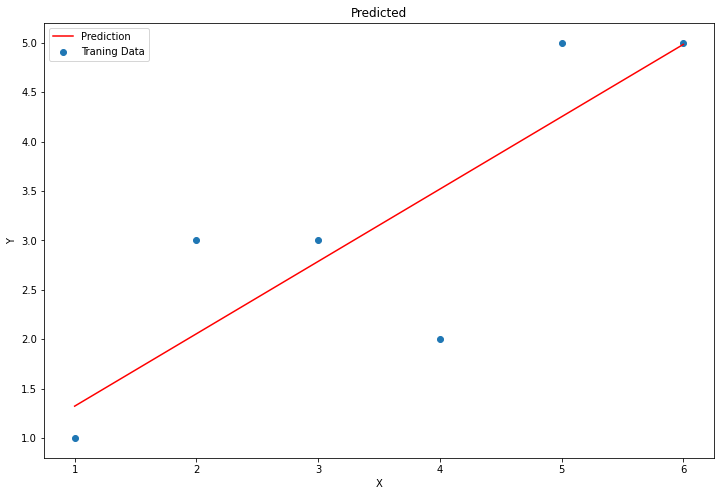

In [19]:
x = np.linspace(data.X.min(), data.X.max(), 100)
f = g[0, 0] + (g[0, 1] * x)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x, f, 'r', label='Prediction')
ax.scatter(data.X, data.Y, label='Traning Data')
ax.legend(loc=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Predicted')

Not bad! Our solution looks like and optimal linear model of the data set. Since the gradient decent function also outputs a vector with the cost at each training iteration, we can plot that as well.

Text(0.5, 1.0, 'Error vs. Training Epoch')

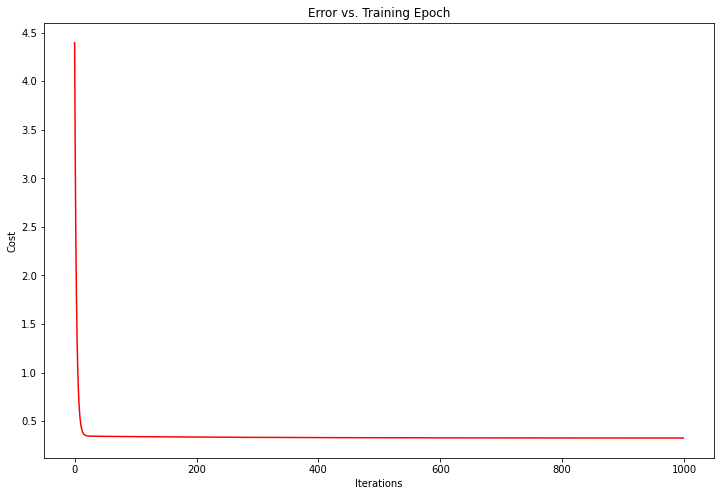

In [20]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(iters), cost, 'r')
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')
ax.set_title('Error vs. Training Epoch')

Notice that the cost always decreases - this is an example of what's called a convex optimization problem. If you were to plot the entire solution space for the problem (i.e. plot the cost as a function of the model parameters for every possible value of the parameters) you would see that it looks like a "bowl" shape with a "basin" representing the optimal solution.

That's all for now! In part 2 we'll finish off the first exercise by extending this example to more than 1 variable. I'll also show how the above solution can be reached by using a popular machine learning library called scikit-learn.